## RNN (using single step approch)

* Single-step approach predicts only the next step (t + delta t) and compares directly with actual values. 

* No feedback loop where predictions become inputs for the next step. 

* More precise evaluation since predictions are independently tested against y_test

In [125]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler


In [126]:
# Load dataset
train_data = pd.read_csv('training_1.csv')
test_data = pd.read_csv('testing_1.csv')

# Normalize `IP Delay (ms)`
scaler = MinMaxScaler(feature_range=(0, 1))
train_data['Normalized IP Delay'] = scaler.fit_transform(train_data[['IP Delay (ms)']])
test_data['Normalized IP Delay'] = scaler.transform(test_data[['IP Delay (ms)']])

print(train_data.head())  # Check the normalized data


   SN  IP Delay (ms)  Normalized IP Delay
0   1      19.265890             0.609268
1   2      19.082069             0.572774
2   3      19.102097             0.576750
3   4      19.090891             0.574525
4   5      18.964052             0.549344


In [127]:
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])  # Sequence of `sequence_length`
        y.append(data[i+sequence_length])   # Target value (next time step)
    return np.array(X), np.array(y)

# Define sequence length
sequence_length = 10

# Prepare training sequences
train_values = train_data['Normalized IP Delay'].values
X_train, y_train = create_sequences(train_values, sequence_length)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

# Prepare testing sequences
test_values = test_data['Normalized IP Delay'].values
X_test, y_test = create_sequences(test_values, sequence_length)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print("X_train Shape:", X_train.shape)
print("y_train Shape:", y_train.shape)
print("X_test Shape:", X_test.shape)
print("y_test Shape:", y_test.shape)


X_train Shape: (190, 10, 1)
y_train Shape: (190,)
X_test Shape: (540, 10, 1)
y_test Shape: (540,)


Epoch 1/20


c:\ML\PYTHON\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.1156 - val_loss: 0.0145
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0191 - val_loss: 0.0023
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0169 - val_loss: 3.2267e-04
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0211 - val_loss: 4.6369e-04
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0158 - val_loss: 4.3405e-04
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0101 - val_loss: 4.8633e-04
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0111 - val_loss: 2.8825e-04
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0161 - val_loss: 1.6414e-04
Epoch 9/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0076 - val_loss: 1.2527e-04
Epoch 10/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0040 - val_loss: 1.4255e-04
Epoch 11/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0110 - val_loss: 2.0501e-04
Epoch 12/20
10/10 ━━━━━━━━━━━━━━━━━━━━

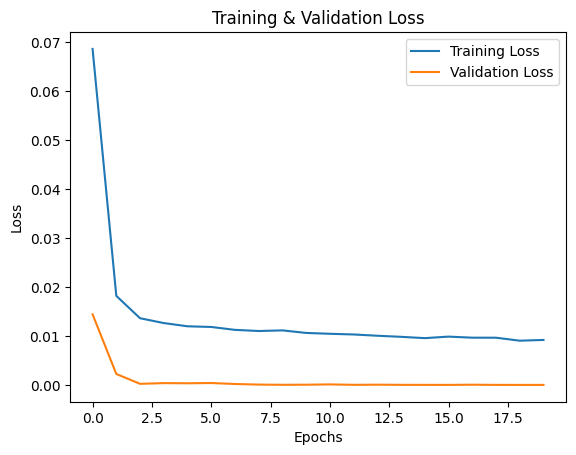

In [128]:
# Define model
model = Sequential([
    SimpleRNN(50, activation='relu', input_shape=(X_train.shape[1], 1)),  # RNN Layer
    Dense(1)  # Single output for next step prediction
])

# Compile with optimized hyperparameters
optimizer = Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=16, validation_split=0.2)

# Plot training progress
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [129]:
# Predict single-step delay for each sequence
single_step_predictions = model.predict(X_test)

# Denormalize predictions
denormalized_predictions = scaler.inverse_transform(single_step_predictions)

# Denormalize actual values
denormalized_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Compare actual vs predicted for first output step
comparison_df = pd.DataFrame({
    'SN': range(1, len(denormalized_actual) + 1),
    'Actual Delay (Step 1)': denormalized_actual[:, 0],
    'Predicted Delay (Step 1)': denormalized_predictions[:, 0],
    'Absolute Diff (ms)': np.abs(denormalized_actual[:, 0] - denormalized_predictions[:, 0])
})

#  Filter for SN 100 to 200
comparison_df_filtered = comparison_df[(comparison_df['SN'] >= 100) & (comparison_df['SN'] <= 200)]

#  Print filtered DataFrame
print(comparison_df_filtered)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
      SN  Actual Delay (Step 1)  Predicted Delay (Step 1)  Absolute Diff (ms)
99   100              19.318819                 19.368099            0.049280
100  101              19.319057                 19.265799            0.053259
101  102              19.184828                 19.219061            0.034233
102  103              19.212008                 19.131422            0.080585
103  104              19.086123                 19.109032            0.022909
..   ...                    ...                       ...                 ...
195  196              18.313169                 18.366261            0.053091
196  197              18.329859                 18.267258            0.062601
197  198              18.321037                 18.231346            0.089691
198  199              18.179893                 18.246748            0.066854
199  200              18.197060                 18.136721            0.060339

[101 rows x 4 columns]


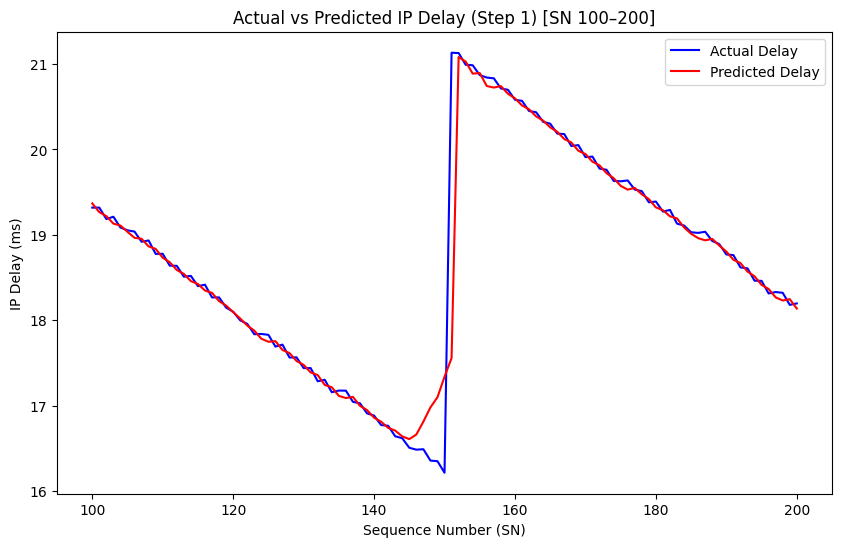

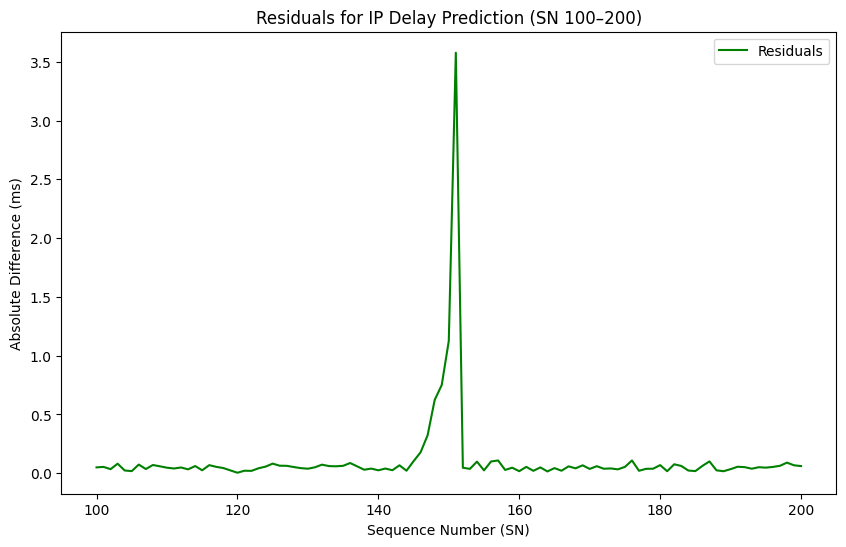

In [130]:

#  Plot actual vs predicted (SN 100–200)
plt.figure(figsize=(10, 6))
plt.plot(comparison_df_filtered['SN'], comparison_df_filtered['Actual Delay (Step 1)'], label='Actual Delay', color='blue')
plt.plot(comparison_df_filtered['SN'], comparison_df_filtered['Predicted Delay (Step 1)'], label='Predicted Delay', color='red')
plt.xlabel('Sequence Number (SN)')
plt.ylabel('IP Delay (ms)')
plt.title('Actual vs Predicted IP Delay (Step 1) [SN 100–200]')
plt.legend()
plt.show()

#  Plot residuals (SN 100–200)
plt.figure(figsize=(10, 6))
plt.plot(comparison_df_filtered['SN'], comparison_df_filtered['Absolute Diff (ms)'], label='Residuals', color='green')
plt.xlabel('Sequence Number (SN)')
plt.ylabel('Absolute Difference (ms)')
plt.title('Residuals for IP Delay Prediction (SN 100–200)')
plt.legend()



### We tried to optimize our results by adjusting the values of Sequence Length, Learning rate, EPOCH Count, Batch Size, Validation split etc. 

In [131]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler


In [132]:
# Load dataset
train_data = pd.read_csv('training_1.csv')
test_data = pd.read_csv('testing_1.csv')

# Normalize `IP Delay (ms)`
scaler = MinMaxScaler(feature_range=(0, 1))
train_data['Normalized IP Delay'] = scaler.fit_transform(train_data[['IP Delay (ms)']])
test_data['Normalized IP Delay'] = scaler.transform(test_data[['IP Delay (ms)']])

print(train_data.head())  # Check the normalized data


   SN  IP Delay (ms)  Normalized IP Delay
0   1      19.265890             0.609268
1   2      19.082069             0.572774
2   3      19.102097             0.576750
3   4      19.090891             0.574525
4   5      18.964052             0.549344


In [133]:
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])  # Sequence of `sequence_length`
        y.append(data[i+sequence_length])   # Target value (next time step)
    return np.array(X), np.array(y)

# Define sequence length
sequence_length = 20

# Prepare training sequences
train_values = train_data['Normalized IP Delay'].values
X_train, y_train = create_sequences(train_values, sequence_length)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

# Prepare testing sequences
test_values = test_data['Normalized IP Delay'].values
X_test, y_test = create_sequences(test_values, sequence_length)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print("X_train Shape:", X_train.shape)
print("y_train Shape:", y_train.shape)
print("X_test Shape:", X_test.shape)
print("y_test Shape:", y_test.shape)


X_train Shape: (180, 20, 1)
y_train Shape: (180,)
X_test Shape: (530, 20, 1)
y_test Shape: (530,)


Epoch 1/50


c:\ML\PYTHON\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - loss: 0.2177 - val_loss: 0.0392
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.1362 - val_loss: 0.0114
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0584 - val_loss: 0.0050
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0246 - val_loss: 0.0319
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0340 - val_loss: 0.0146
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0202 - val_loss: 0.0074
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0201 - val_loss: 0.0051
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0175 - val_loss: 0.0052
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0224 - val_loss: 0.0063
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0240 - val_loss: 0.0067
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0145 - val_loss: 0.0051
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0202 - val_loss: 0.0049
Epoch 13/50


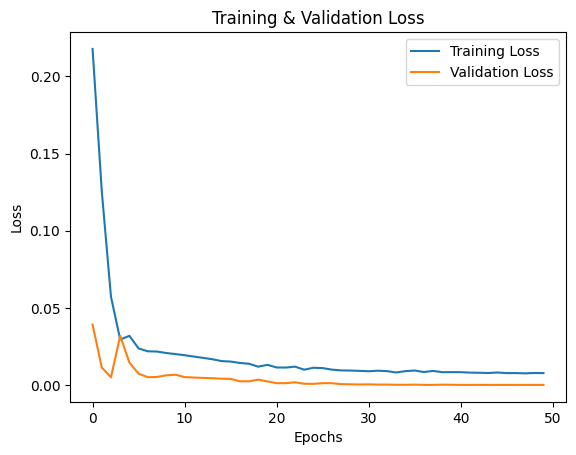

In [134]:
# Define model
model = Sequential([
    SimpleRNN(50, activation='relu', input_shape=(X_train.shape[1], 1)),  # RNN Layer
    Dense(1)  # Single output for next step prediction
])

# Compile with optimized hyperparameters
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Plot training progress
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [135]:
# Predict single-step delay for each sequence
single_step_predictions = model.predict(X_test)

# Denormalize predictions
denormalized_predictions = scaler.inverse_transform(single_step_predictions)

# Denormalize actual values
denormalized_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Compare actual vs predicted for first output step
comparison_df = pd.DataFrame({
    'SN': range(1, len(denormalized_actual) + 1),
    'Actual Delay (Step 1)': denormalized_actual[:, 0],
    'Predicted Delay (Step 1)': denormalized_predictions[:, 0],
    'Absolute Diff (ms)': np.abs(denormalized_actual[:, 0] - denormalized_predictions[:, 0])
})

#  Filter for SN 100 to 200
comparison_df_filtered = comparison_df[(comparison_df['SN'] >= 100) & (comparison_df['SN'] <= 200)]

#  Print filtered DataFrame
print(comparison_df_filtered)




17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
      SN  Actual Delay (Step 1)  Predicted Delay (Step 1)  Absolute Diff (ms)
99   100              18.778086                 18.766726            0.011360
100  101              18.639088                 18.710863            0.071775
101  102              18.636942                 18.632532            0.004410
102  103              18.509865                 18.569168            0.059303
103  104              18.518925                 18.493607            0.025318
..   ...                    ...                       ...                 ...
195  196              17.817020                 17.774902            0.042118
196  197              17.702103                 17.731714            0.029612
197  198              17.645836                 17.663588            0.017752
198  199              17.546177                 17.592852            0.046675
199  200              17.506123                 17.523018            0.016895

[101 rows x 4 columns]


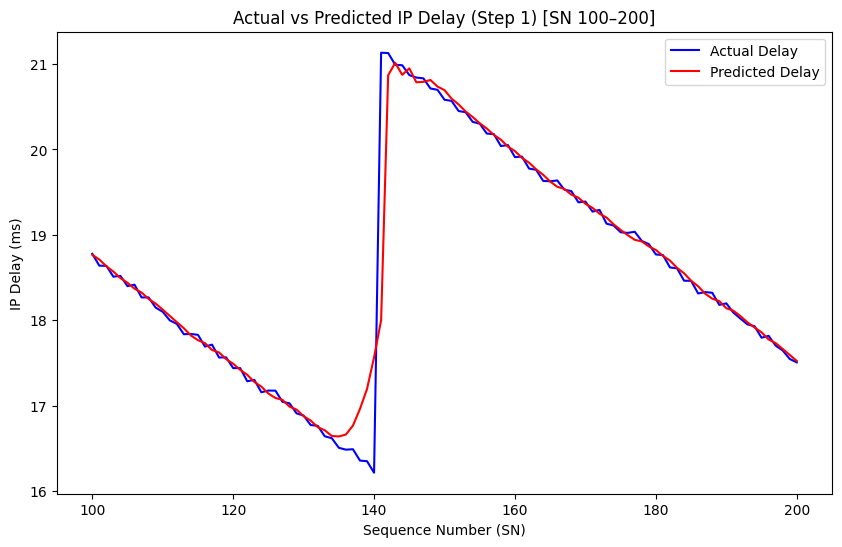

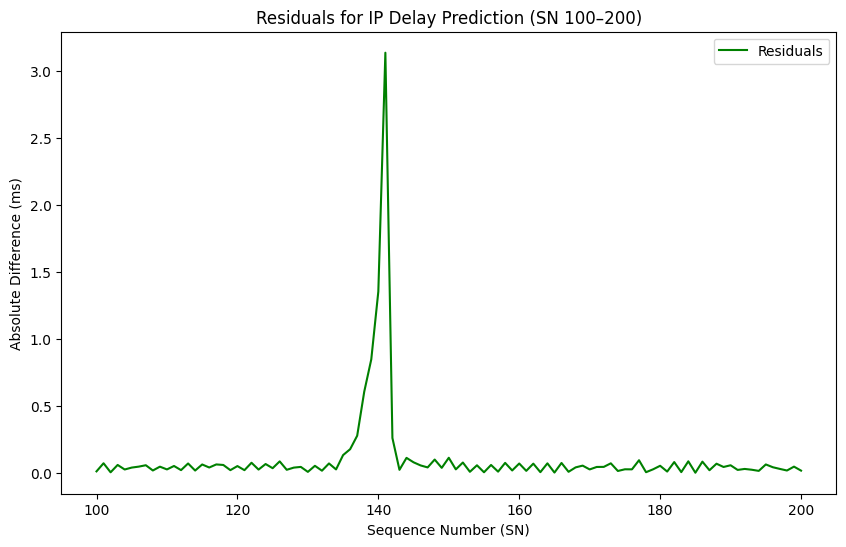

In [136]:
#  Plot actual vs predicted (SN 100–200)
plt.figure(figsize=(10, 6))
plt.plot(comparison_df_filtered['SN'], comparison_df_filtered['Actual Delay (Step 1)'], label='Actual Delay', color='blue')
plt.plot(comparison_df_filtered['SN'], comparison_df_filtered['Predicted Delay (Step 1)'], label='Predicted Delay', color='red')
plt.xlabel('Sequence Number (SN)')
plt.ylabel('IP Delay (ms)')
plt.title('Actual vs Predicted IP Delay (Step 1) [SN 100–200]')
plt.legend()
plt.show()

#  Plot residuals (SN 100–200)
plt.figure(figsize=(10, 6))
plt.plot(comparison_df_filtered['SN'], comparison_df_filtered['Absolute Diff (ms)'], label='Residuals', color='green')
plt.xlabel('Sequence Number (SN)')
plt.ylabel('Absolute Difference (ms)')
plt.title('Residuals for IP Delay Prediction (SN 100–200)')
plt.legend()
plt.show()

# COMPARISON B/W VALUES AFTER THE ALTERING THE PARAMETERS 

### SEQUENCE LENGTH = 10, LEARNING RATE =0.01, EPOCHS =20, BATCH SIZE =16

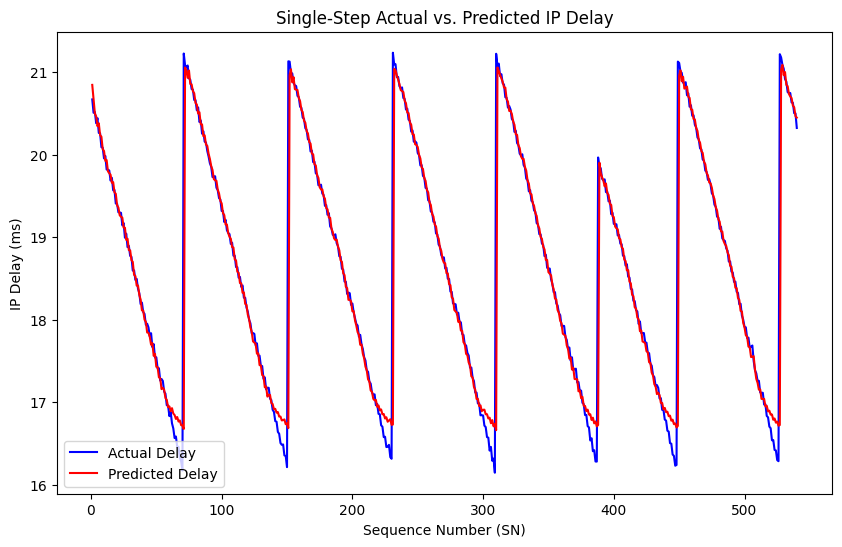

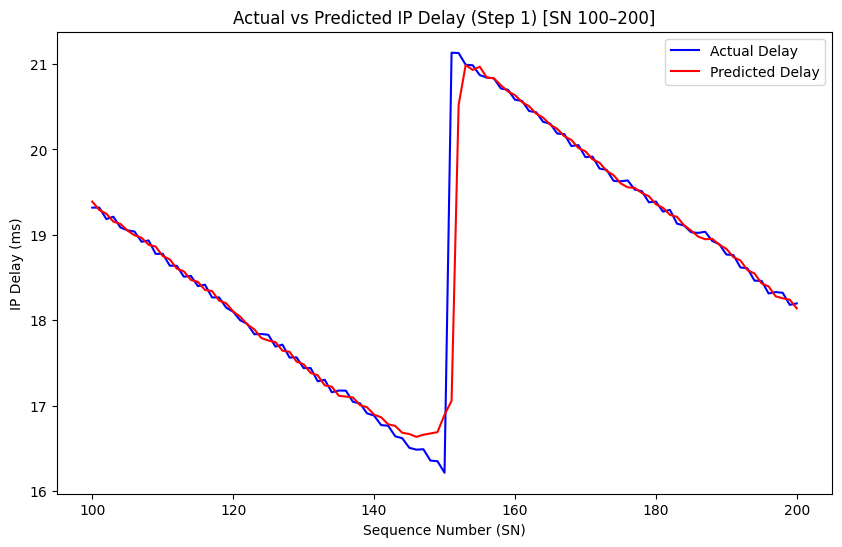

### SEQUENCE LENGTH = 20, LEARNING RATE =0.001, EPOCHS =50, BATCH SIZE =32

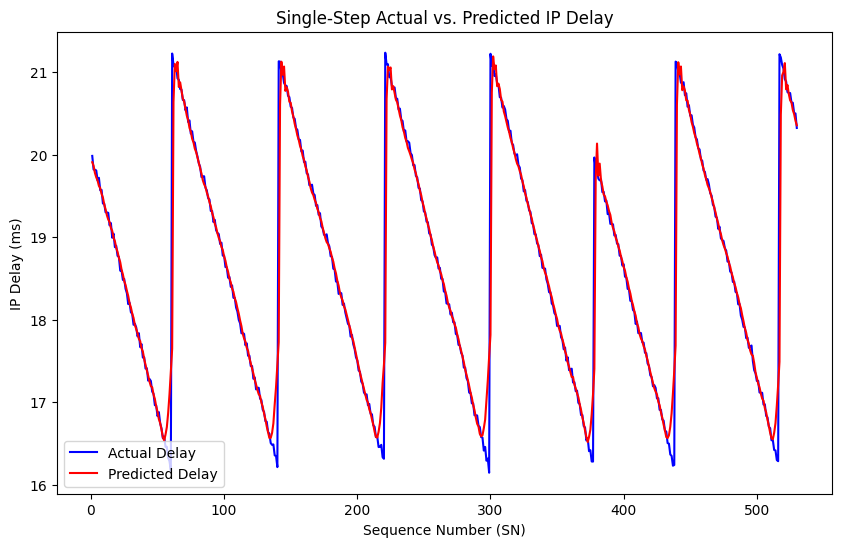


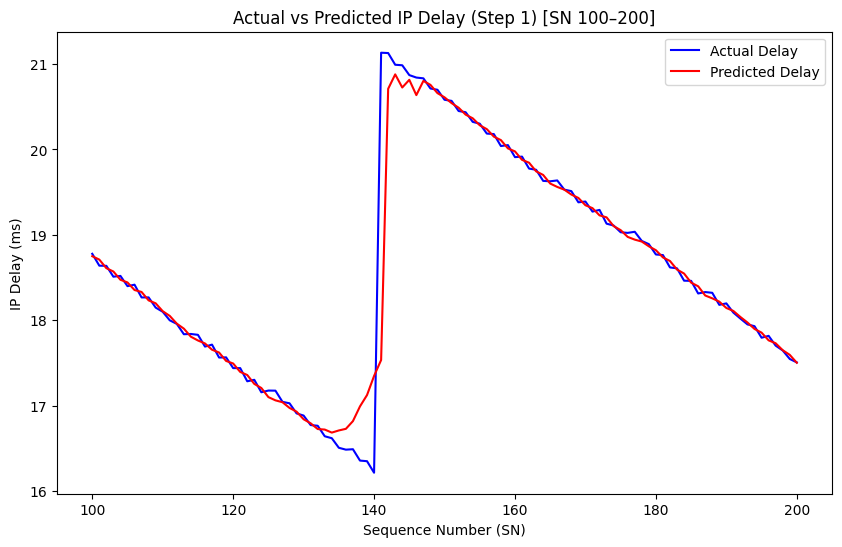

## Single step approch with multiple outputs           (Sequence-to-Sequence Approach)


* Predict the next k timesteps (e.g., t+1 to t+5) from one input sequence [t0...tN]
* No Feedback loop is used

Epoch 1/20


c:\ML\PYTHON\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.2362 - val_loss: 0.0143
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0518 - val_loss: 0.0091
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0355 - val_loss: 0.0110
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0254 - val_loss: 0.0057
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0213 - val_loss: 0.0024
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0163 - val_loss: 0.0018
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0191 - val_loss: 0.0010
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0299 - val_loss: 0.0012
Epoch 9/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0226 - val_loss: 7.4168e-04
Epoch 10/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0165 - val_loss: 5.3440e-04
Epoch 11/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0132 - val_loss: 0.0011
Epoch 12/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0218

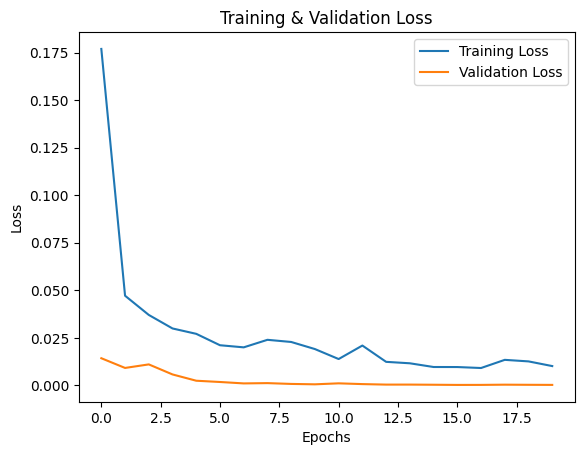

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
      SN  Actual Delay (Step 1)  Predicted Delay (Step 1)  Absolute Diff (ms)
99   100              19.318819                 19.497026            0.178207
100  101              19.319057                 19.387745            0.068687
101  102              19.184828                 19.347603            0.162775
102  103              19.212008                 19.240568            0.028561
103  104              19.086123                 19.221218            0.135096
..   ...                    ...                       ...                 ...
195  196              18.313169                 18.432043            0.118874
196  197              18.329859                 18.314268            0.015591
197  198              18.321037                 18.284225            0.036812
198  199              18.179893                 18.261675            0.081781
199  200              18.197060                 18.167782            0.029278

[101 rows x 4 columns]


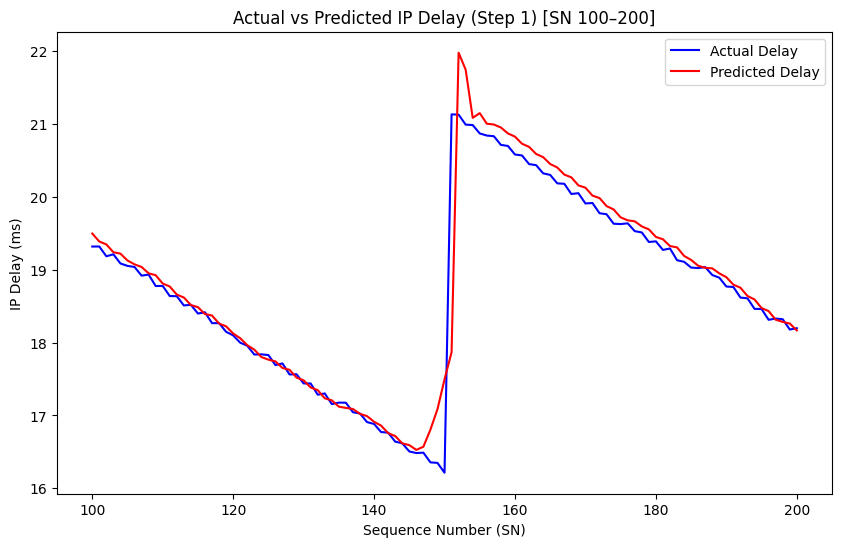

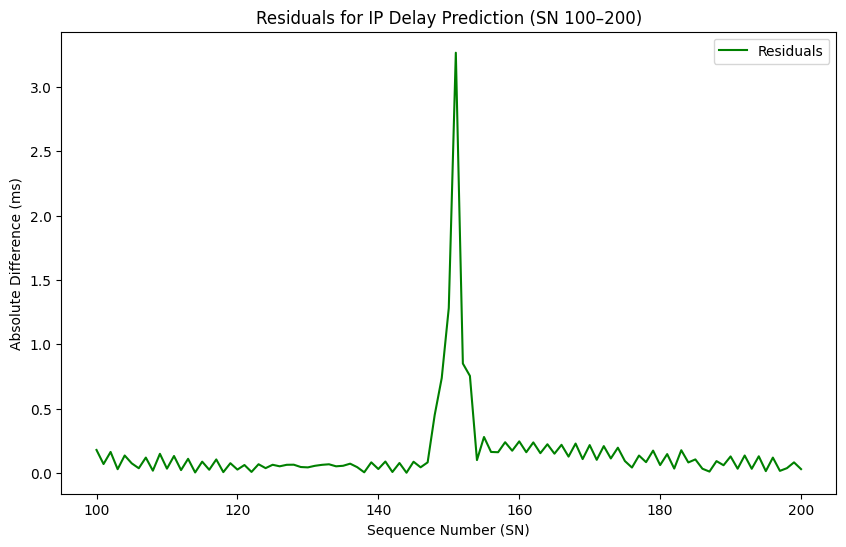

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler

# Load dataset
train_data = pd.read_csv('training_1.csv')
test_data = pd.read_csv('testing_1.csv')

# Normalize IP Delay (ms)
scaler = MinMaxScaler(feature_range=(0, 1))
train_data['Normalized IP Delay'] = scaler.fit_transform(train_data[['IP Delay (ms)']])
test_data['Normalized IP Delay'] = scaler.transform(test_data[['IP Delay (ms)']])

# Set sequence length and output steps
sequence_length = 10  # Number of input timesteps
output_steps = 5      # Number of output timesteps

# Extract normalized values
train_values = train_data['Normalized IP Delay'].values
test_values = test_data['Normalized IP Delay'].values

# Function to create sequences
def create_seq2seq_sequences(data, input_len, output_len):
    X, y = [], []
    for i in range(len(data) - input_len - output_len):
        X.append(data[i:i+input_len])
        y.append(data[i+input_len:i+input_len+output_len])
    return np.array(X), np.array(y)

# Prepare training and test data
X_train, y_train = create_seq2seq_sequences(train_values, sequence_length, output_steps)
X_test, y_test = create_seq2seq_sequences(test_values, sequence_length, output_steps)

# Reshape inputs for RNN [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Reshape outputs [samples, output_steps]
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1]))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1]))

# Build model
model = Sequential([
    SimpleRNN(50, activation='relu', input_shape=(sequence_length, 1)),
    Dense(output_steps)
])

model.compile(optimizer=Adam(0.01), loss='mse')

# Train model
history = model.fit(X_train, y_train, epochs=20, batch_size=16, validation_split=0.2)

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Predict
predictions = model.predict(X_test)

# Denormalize predictions and ground truth
denormalized_predictions = scaler.inverse_transform(predictions)
denormalized_actual = scaler.inverse_transform(y_test)

# Compare actual vs predicted for first output step
comparison_df = pd.DataFrame({
    'SN': range(1, len(denormalized_actual) + 1),
    'Actual Delay (Step 1)': denormalized_actual[:, 0],
    'Predicted Delay (Step 1)': denormalized_predictions[:, 0],
    'Absolute Diff (ms)': np.abs(denormalized_actual[:, 0] - denormalized_predictions[:, 0])
})

#  Filter for SN 100 to 200
comparison_df_filtered = comparison_df[(comparison_df['SN'] >= 100) & (comparison_df['SN'] <= 200)]

#  Print filtered DataFrame
print(comparison_df_filtered)

#  Plot actual vs predicted (SN 100–200)
plt.figure(figsize=(10, 6))
plt.plot(comparison_df_filtered['SN'], comparison_df_filtered['Actual Delay (Step 1)'], label='Actual Delay', color='blue')
plt.plot(comparison_df_filtered['SN'], comparison_df_filtered['Predicted Delay (Step 1)'], label='Predicted Delay', color='red')
plt.xlabel('Sequence Number (SN)')
plt.ylabel('IP Delay (ms)')
plt.title('Actual vs Predicted IP Delay (Step 1) [SN 100–200]')
plt.legend()
plt.show()

#  Plot residuals (SN 100–200)
plt.figure(figsize=(10, 6))
plt.plot(comparison_df_filtered['SN'], comparison_df_filtered['Absolute Diff (ms)'], label='Residuals', color='green')
plt.xlabel('Sequence Number (SN)')
plt.ylabel('Absolute Difference (ms)')
plt.title('Residuals for IP Delay Prediction (SN 100–200)')
plt.legend()
plt.show()
